In [1]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [2]:
train_csv="/home/deeplearning/Kaggle/avito/input/train.csv"
test_csv="/home/deeplearning/Kaggle/avito/input/test.csv"

In [3]:
train_df = pd.read_csv(train_csv, parse_dates=["activation_date"])
train_df = train_df.replace(np.nan, -1, regex=True)
test_df = pd.read_csv(test_csv, parse_dates=["activation_date"])
test_df = test_df.replace(np.nan, -1, regex=True)

In [4]:
def title_features(train_df, test_df):
    from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
    from sklearn.decomposition import TruncatedSVD

    train_df["title_nwords"] = train_df["title"].apply(lambda x: len(x.split()))
    test_df["title_nwords"] = test_df["title"].apply(lambda x: len(x.split()))
#     extract_columns.append("title_nwords")

    tfidf_vec = TfidfVectorizer(ngram_range=(1, 1))
    full_tfidf = tfidf_vec.fit_transform(train_df['title'].values.tolist() + test_df['title'].values.tolist())
    train_tfidf = tfidf_vec.transform(train_df['title'].values.tolist())
    test_tfidf = tfidf_vec.transform(test_df['title'].values.tolist())

    ### SVD Components ###
    n_comp = 3
    svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    svd_obj.fit(full_tfidf)
    train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
    test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    train_svd.columns = ['svd_title_' + str(i + 1) for i in range(n_comp)]
    test_svd.columns = ['svd_title_' + str(i + 1) for i in range(n_comp)]

    train_df = pd.concat([train_df, train_svd], axis=1)
    test_df = pd.concat([test_df, test_svd], axis=1)

    return train_df, test_df


def description_features(train_df, test_df):
    from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
    from sklearn.decomposition import TruncatedSVD

    ## Filling missing values ##
    train_df["description"].fillna("NA", inplace=True)
    test_df["description"].fillna("NA", inplace=True)

    train_df["description"] = train_df["description"].apply(lambda x: str(x))
    test_df["description"] = test_df["description"].apply(lambda x: str(x))

    train_df["desc_nwords"] = train_df["description"].apply(lambda x: len(str(x).split()))
    test_df["desc_nwords"] = test_df["description"].apply(lambda x: len(str(x).split()))
#     extract_columns.append("desc_nwords")

    ### TFIDF Vectorizer ###
    tfidf_vec = TfidfVectorizer(ngram_range=(1, 1), max_features=100000)
    full_tfidf = tfidf_vec.fit_transform(
        train_df['description'].values.tolist() + test_df['description'].values.tolist())
    train_tfidf = tfidf_vec.transform(train_df['description'].values.tolist())
    test_tfidf = tfidf_vec.transform(test_df['description'].values.tolist())

    ### SVD Components ###
    n_comp = 3
    svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    svd_obj.fit(full_tfidf)
    train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
    test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    train_svd.columns = ['svd_desc_' + str(i + 1) for i in range(n_comp)]
    test_svd.columns = ['svd_desc_' + str(i + 1) for i in range(n_comp)]
    train_df = pd.concat([train_df, train_svd], axis=1)
    test_df = pd.concat([test_df, test_svd], axis=1)

    return train_df, test_df

Create feature has_img

In [5]:
# For train
train_df["has_img"] = train_df.image.apply(lambda x: False if x is pd.np.nan else True)
# For test
test_df["has_img"] = test_df.image.apply(lambda x: False if x is pd.np.nan else True)

Fix missing price

In [6]:
# # For train
# fix_missing(train_df, train_df["price"], "price", {})
# # For test
# fix_missing(test_df, test_df["price"], "price", {})

In [7]:
#get log of price
train_df["price"] = train_df.price.apply(lambda x: np.log1p(x))
train_df["price"] = train_df.price.apply(lambda x: -1 if x == -np.inf else x)
test_df["price"] = test_df.price.apply(lambda x: np.log1p(x))
test_df["price"] = test_df.price.apply(lambda x: -1 if x == -np.inf else x)

Fix missing image_top_1

In [8]:
# # For train
# fix_missing(train_df, train_df["image_top_1"], "image_top_1", {})
# # For test
# fix_missing(test_df, test_df["image_top_1"], "image_top_1", {})

Add time features

In [9]:
# For train
train_df["year"] = train_df.activation_date.dt.year
train_df["month"] = train_df.activation_date.dt.month
train_df["week"] = train_df.activation_date.dt.week
train_df["weekday"] = train_df.activation_date.dt.weekday
train_df["dayofyear"] = train_df.activation_date.dt.dayofyear
train_df["day"] = train_df.activation_date.dt.day

# For test
test_df["year"] = test_df.activation_date.dt.year
test_df["month"] = test_df.activation_date.dt.month
test_df["week"] = test_df.activation_date.dt.week
test_df["weekday"] = test_df.activation_date.dt.weekday
test_df["dayofyear"] = test_df.activation_date.dt.dayofyear
test_df["day"] = test_df.activation_date.dt.day

Extract title and description features

In [10]:
train_df, test_df = description_features(train_df, test_df)
train_df, test_df = title_features(train_df, test_df)

In [11]:
unused_columns = [
    "item_id", "user_id", "title", "description",
    "activation_date", "image"
]

In [12]:
# Drop un-used columns
train_df = train_df.drop(unused_columns, axis=1)
test_df = test_df.drop(unused_columns, axis=1)

In [13]:
train_df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
region,Свердловская область,Самарская область,Ростовская область,Татарстан,Волгоградская область,Татарстан,Нижегородская область,Пермский край,Оренбургская область,Нижегородская область,Ханты-Мансийский АО,Тюменская область,Оренбургская область,Ростовская область,Башкортостан,Татарстан,Краснодарский край,Новосибирская область,Омская область,Белгородская область
city,Екатеринбург,Самара,Ростов-на-Дону,Набережные Челны,Волгоград,Чистополь,Нижний Новгород,Пермь,Оренбург,Нижний Новгород,Ханты-Мансийск,Заводоуковск,Оренбург,Ростов-на-Дону,Туймазы,Казань,Краснодар,Новосибирск,Москаленки,Белгород
parent_category_name,Личные вещи,Для дома и дачи,Бытовая электроника,Личные вещи,Транспорт,Личные вещи,Для дома и дачи,Личные вещи,Личные вещи,Личные вещи,Недвижимость,Личные вещи,Личные вещи,Бытовая электроника,Животные,Личные вещи,Транспорт,Личные вещи,Личные вещи,Недвижимость
category_name,Товары для детей и игрушки,Мебель и интерьер,Аудио и видео,Товары для детей и игрушки,Автомобили,Товары для детей и игрушки,Ремонт и строительство,"Одежда, обувь, аксессуары","Одежда, обувь, аксессуары",Детская одежда и обувь,Квартиры,"Одежда, обувь, аксессуары",Товары для детей и игрушки,Товары для компьютера,Собаки,"Одежда, обувь, аксессуары",Автомобили,Товары для детей и игрушки,"Одежда, обувь, аксессуары","Дома, дачи, коттеджи"
param_1,Постельные принадлежности,Другое,"Видео, DVD и Blu-ray плееры",Автомобильные кресла,С пробегом,Автомобильные кресла,Сантехника и сауна,Женская одежда,Женская одежда,Для девочек,Сдам,Женская одежда,Товары для школы,Мониторы,Немецкая овчарка,Женская одежда,С пробегом,Игрушки,Женская одежда,Сниму
param_2,-1,-1,-1,-1,ВАЗ (LADA),-1,-1,Джинсы,Платья и юбки,Обувь,На длительный срок,Джинсы,-1,-1,-1,Платья и юбки,Chevrolet,-1,Верхняя одежда,Коттедж
param_3,-1,-1,-1,-1,2110,-1,-1,26,> 50 (XXL),25,1,Без размера,-1,-1,-1,42–44 (S),Lanos,-1,44–46 (M),На длительный срок
price,5.99396,8.0067,8.2943,7.69667,10.5967,7.17089,9.30574,6.21661,6.21661,5.99396,9.79818,0.693147,4.26268,7.82445,8.51739,6.68586,11.8494,6.21661,6.90875,11.5129
item_seq_number,2,19,9,286,3,9,125,61,85,136,6,4,15,47,6,86,201,9,4,5
user_type,Private,Private,Private,Company,Private,Private,Private,Private,Private,Company,Private,Shop,Private,Private,Private,Private,Company,Private,Private,Private


In [14]:
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [15]:
train_df.to_csv("fastai_train.csv", index=False)
test_df.to_csv("fastai_test.csv", index=False)

In [ ]:
train_df = pd.read_csv("fastai_train.csv")
test_df = pd.read_csv("fastai_test.csv")

In [17]:
# train_df.to_feather('fastai_train')
# test_df.to_feather('fastai_test')

In [18]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [19]:
# train_df = pd.read_feather('fastai_train')
# test_df = pd.read_feather('fastai_test')
train_df = pd.read_csv("fastai_train.csv")
test_df = pd.read_csv("fastai_test.csv")

In [20]:
display(train_df.head(5).T)

,0,1,2,3,4
index,0,1,2,3,4
region,Свердловская область,Самарская область,Ростовская область,Татарстан,Волгоградская область
city,Екатеринбург,Самара,Ростов-на-Дону,Набережные Челны,Волгоград
parent_category_name,Личные вещи,Для дома и дачи,Бытовая электроника,Личные вещи,Транспорт
category_name,Товары для детей и игрушки,Мебель и интерьер,Аудио и видео,Товары для детей и игрушки,Автомобили
param_1,Постельные принадлежности,Другое,"Видео, DVD и Blu-ray плееры",Автомобильные кресла,С пробегом
param_2,-1,-1,-1,-1,ВАЗ (LADA)
param_3,-1,-1,-1,-1,2110
price,5.99396,8.0067,8.2943,7.69667,10.5967
item_seq_number,2,19,9,286,3


In [21]:
cat_vars = [
    "region", "city", "parent_category_name", "category_name",
    "param_1", "param_2", "param_3", "user_type",
    "image_top_1"
]

contin_vars = [
    "item_seq_number", "price", "svd_desc_1", "svd_desc_2",
    "svd_desc_3", "desc_nwords", "svd_title_1", "svd_title_2", "svd_title_3", "title_nwords",
    "year", "month", "week", "weekday", "day", "dayofyear", 
]

In [22]:
n = len(train_df); n

1503424

In [23]:
dep = 'deal_probability'
train_df = train_df[cat_vars+contin_vars+[dep]].copy()

In [24]:
test_df[dep] = 0
test_df = test_df[cat_vars+contin_vars+[dep]].copy()

In [25]:
for v in cat_vars: train_df[v] = train_df[v].astype('category').cat.as_ordered()

In [26]:
train_df.head(5).T

,0,1,2,3,4
region,Свердловская область,Самарская область,Ростовская область,Татарстан,Волгоградская область
city,Екатеринбург,Самара,Ростов-на-Дону,Набережные Челны,Волгоград
parent_category_name,Личные вещи,Для дома и дачи,Бытовая электроника,Личные вещи,Транспорт
category_name,Товары для детей и игрушки,Мебель и интерьер,Аудио и видео,Товары для детей и игрушки,Автомобили
param_1,Постельные принадлежности,Другое,"Видео, DVD и Blu-ray плееры",Автомобильные кресла,С пробегом
param_2,-1,-1,-1,-1,ВАЗ (LADA)
param_3,-1,-1,-1,-1,2110
user_type,Private,Private,Private,Company,Private
image_top_1,1008,692,3032,796,2264
item_seq_number,2,19,9,286,3


In [27]:
apply_cats(test_df, train_df)

In [28]:
for v in contin_vars:
    train_df[v] = train_df[v].astype('float32')
    test_df[v] = test_df[v].astype('float32')

In [29]:
df, y, nas, mapper = proc_df(train_df, 'deal_probability', do_scale=True)

In [30]:
df_test, _, nas, mapper = proc_df(test_df, 'deal_probability', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [31]:
val_idx = get_cv_idxs(n, val_pct=0.2)

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_predicted, y_actual):
    return sqrt(mean_squared_error(y_actual, y_predicted))

def mse(y_predicted, y_actual):
    return mean_squared_error(y_actual, y_predicted)

y_range = (0, 1)

In [33]:
md = ColumnarModelData.from_data_frame(".", val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=2048,
                                       test_df=df_test)

In [34]:
cat_sz = [(c, len(train_df[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(100, (c+1)//2)) for _,c in cat_sz]

In [35]:
def get_model():
    return md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0., 1, [128,128,64,64, 32], [0.,0.,0.,0.,0.], y_range=y_range, use_bn=True)

In [41]:
m = get_model()

/home/deeplearning/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai-0.6-py3.6.egg/fastai/column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/deeplearning/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai-0.6-py3.6.egg/fastai/column_data.py:103: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


epoch      trn_loss   val_loss   
    0      0.125299   0.127087  



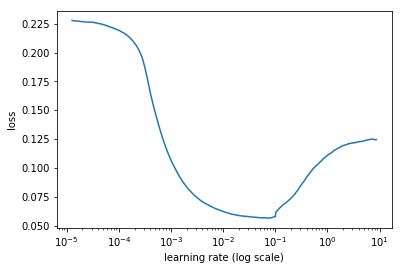

In [37]:
m.lr_find()
m.sched.plot()

In [42]:
lr = 1e-2

In [43]:
m.fit(lr, 5, metrics=[rmse])

epoch      trn_loss   val_loss   rmse       
    0      0.0531     0.052827   0.229808  
    1      0.052345   0.052377   0.228829  
    2      0.051659   0.052638   0.229397  
    3      0.051182   0.051808   0.227584  
    4      0.050575   0.052368   0.228803  



[0.05236795859086782, 0.22880315922991729]

In [40]:
m.fit(lr, 3, metrics=[rmse], cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   rmse       
    0      0.049315   0.050523   0.22474   
    1      0.050041   0.050868   0.225504  
    2      0.048174   0.050744   0.225232  
    3      0.049499   0.050794   0.225342  
    4      0.048251   0.051135   0.226093  
    5      0.047002   0.051329   0.226525  
    6      0.044962   0.052081   0.228177  



[0.052080944624425085, 0.2281765405649109]

In [48]:
m.

In [ ]:
m.fit(lr, 2, metrics=[rmse], cycle_len=4)

In [52]:
pred_test=m.predict(is_test=True)

In [53]:
submission = pd.read_csv("/home/deeplearning/Kaggle/avito/input/sample_submission.csv")
submission['deal_probability'] = pred_test
submission.to_csv("submission_fastai.csv", index=False)